In [24]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import numpy as np
import cv2
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception,VGG16,ResNet50
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy.random import seed

# Pre-Processing 

In [25]:
BASE_PATH = '../input/siim-isic-melanoma-classification'

## Resizing all the images

In [26]:
# Reading the data
path = '../input/skin-cancer-mnist-ham10000/'
images_path = {os.path.splitext(os.path.basename(x))[0]:x for x in glob.glob(os.path.join(path,'*','*.jpg'))}

In [27]:
# Encoding target values
lesion_type_dict = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
    
}

In [28]:
# Reading Metadata csv file
skin_df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [29]:
# Adding extra columns and appending the required created columns in final dataframe
skin_df['path'] = skin_df['image_id'].map(images_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [30]:
# Checking the dataframe info.
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


In [31]:
# Image Reading and Resizing.
IMAGE_SIZE = 71
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img
train_img = []
for img_name in tqdm(skin_df['path'].values):
  train_img.append(read_img(img_name))

100%|██████████| 10015/10015 [01:38<00:00, 102.18it/s]


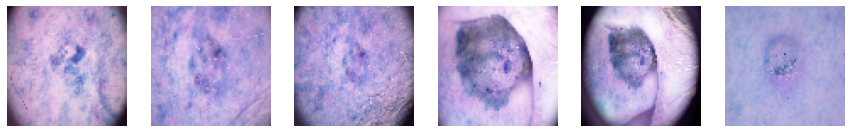

In [32]:
#Visulaizing the images
plt.figure(figsize=(15,12))
for i in range(1,7,1):
    plt.subplot(1,6,i)
    plt.imshow(train_img[i])
    plt.axis('off')
plt.show()

In [33]:
# Converting it into float arrays and normalizing it
X = np.array(train_img,np.float32)/255
print(X.shape)

(10015, 71, 71, 3)


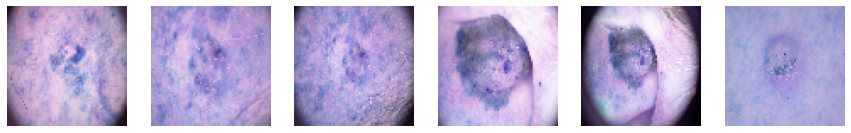

In [34]:
#Visulaizing the normalized images
plt.figure(figsize=(15,12))
for i in range(1,7,1):
    plt.subplot(1,6,i)
    plt.imshow(X[i])
    plt.axis('off')
plt.show()

In [35]:
# Creating Target
y = np.array(skin_df['cell_type_idx'])

In [36]:
# Splitting the data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.10,random_state=28,stratify=y)
x_train,x_val,y_train,y_val =   train_test_split(x_train,y_train,test_size=0.10,random_state=28,stratify=y_train)

In [37]:
# One-Hot Encoding values
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val , num_classes=7)

# Creating CNN Model

In [38]:
# Defining base model using Xception module from Keras
training_shape = (71,71,3)
base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)
for layer in base_model.layers:
    layer.trainable = True                         # Training all layers from scratch

In [39]:
#Adding layers at end
n_classes = 7
model = base_model.output
model = Flatten()(model)
model = Dense(128)(model)
model = Dropout(0.5)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
output = Dense(n_classes, activation='softmax')(model)
model = Model(inputs=base_model.input, outputs=output)

In [40]:
# Compiling the model
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [41]:
# Model Summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [42]:
# Defining callback Methods
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [43]:
# Fitting the model
history = model.fit(x_train,
                    y_train,
                    epochs=n_epoch,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(x_val,y_val)
                   )

Epoch 1/30
254/254 [==============================] - 24s 66ms/step - loss: 1.0170 - accuracy: 0.6449 - val_loss: 1.3961 - val_accuracy: 0.6286
Epoch 2/30
254/254 [==============================] - 16s 61ms/step - loss: 0.6930 - accuracy: 0.7668 - val_loss: 0.9191 - val_accuracy: 0.7118
Epoch 3/30
254/254 [==============================] - 16s 61ms/step - loss: 0.5481 - accuracy: 0.8111 - val_loss: 0.8561 - val_accuracy: 0.7539
Epoch 4/30
254/254 [==============================] - 16s 61ms/step - loss: 0.4546 - accuracy: 0.8502 - val_loss: 1.3575 - val_accuracy: 0.6430
Epoch 5/30
254/254 [==============================] - 16s 61ms/step - loss: 0.3998 - accuracy: 0.8682 - val_loss: 0.7497 - val_accuracy: 0.7705
Epoch 6/30
254/254 [==============================] - 16s 61ms/step - loss: 0.2982 - accuracy: 0.9033 - val_loss: 0.6856 - val_accuracy: 0.7827
Epoch 7/30
254/254 [==============================] - 16s 61ms/step - loss: 0.2456 - accuracy: 0.9227 - val_loss: 0.8480 - val_accuracy:

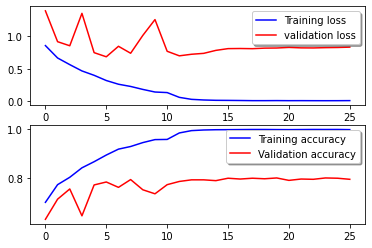

In [44]:
# Plotting the results on Graph
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [45]:
#Extaracting Features from last 4 layers of the model
model2 = Model(model.input,model.layers[-4].output)
predictions = model2.predict(X)
predictions[0]

array([ 25.24031   , -12.619687  ,  10.570349  , -13.57763   ,
         8.013897  ,  -2.291171  ,  -9.106709  ,  20.30404   ,
       -13.932624  ,  11.173974  ,  -2.1643772 ,  -6.1019435 ,
        -6.321358  ,  10.499014  ,  20.049866  ,  11.955248  ,
       -22.621286  , -33.361618  ,  -4.918304  ,   1.940707  ,
        31.56103   ,  41.15267   ,   4.016291  , -29.67645   ,
       -15.695061  ,  10.878134  , -16.48367   ,  30.478085  ,
       -16.999758  , -12.91704   ,  -2.0735304 ,  29.557983  ,
        -5.6356797 ,  -4.742655  ,  35.65807   ,  -8.546572  ,
        -7.755441  ,  41.085815  ,  32.267612  , -10.974103  ,
       -10.594818  ,  -2.2686543 ,  -4.1889358 , -13.476786  ,
        -1.3267618 ,  30.889332  , -13.185356  ,  11.291416  ,
        -2.237436  ,  16.808895  ,   5.937426  ,  -9.694499  ,
        39.139683  ,  38.538544  ,   5.4038835 ,  17.909775  ,
         1.1479832 , -10.71385   ,  -6.5527787 ,   7.0642786 ,
        -8.2082205 , -15.773778  ,   4.844172  ,  28.04

In [46]:
print(len(predictions[0]))

128


In [47]:
X[0]


array([[[0.76862746, 0.60784316, 0.7529412 ],
        [0.75686276, 0.6       , 0.74509805],
        [0.75686276, 0.5764706 , 0.7529412 ],
        ...,
        [0.6784314 , 0.6313726 , 0.7764706 ],
        [0.6156863 , 0.58431375, 0.75686276],
        [0.6627451 , 0.61960787, 0.7607843 ]],

       [[0.7254902 , 0.5647059 , 0.7529412 ],
        [0.7254902 , 0.60784316, 0.7490196 ],
        [0.7882353 , 0.62352943, 0.76862746],
        ...,
        [0.61960787, 0.60784316, 0.77254903],
        [0.5921569 , 0.5882353 , 0.75686276],
        [0.64705884, 0.5921569 , 0.7607843 ]],

       [[0.7490196 , 0.60784316, 0.74509805],
        [0.77254903, 0.62352943, 0.77254903],
        [0.7764706 , 0.6313726 , 0.76862746],
        ...,
        [0.6313726 , 0.59607846, 0.7647059 ],
        [0.60784316, 0.58431375, 0.7647059 ],
        [0.5686275 , 0.5529412 , 0.72156864]],

       ...,

       [[0.68235296, 0.54509807, 0.6784314 ],
        [0.68235296, 0.57254905, 0.70980394],
        [0.7058824 , 0

In [48]:
# Concatenating the predictions with final dataframe
data_df  = skin_df
complete_data = pd.concat([data_df, pd.DataFrame(predictions)], axis=1)
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,...,118,119,120,121,122,123,124,125,126,127
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,17.455019,-17.541616,-22.678017,-13.329155,-13.605341,23.102402,-7.239761,3.092264,2.457997,-12.725587
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,13.998692,-13.239396,-11.486475,-11.269559,-2.500127,17.545399,2.364401,-3.426668,-2.272249,-10.412862
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,-6.430649,-25.911333,-26.341228,-4.388151,-24.977659,27.818998,-9.872917,20.378902,20.541527,-7.190818
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,9.125769,-1.833889,4.727889,32.418152,21.367289,-0.775506,4.214876,-2.981498,5.902585,18.539011
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,0.076562,-21.089304,-14.151516,-13.420930,1.295959,31.953680,8.336804,6.926035,9.455658,11.012508


In [49]:
# saving Models

model_json = model2.to_json()
with open("model_v2.json", "w") as json_file:
    json_file.write(model_json)
    
completemodel_json = model.to_json()
with open("completemodel1.json", "w") as json_file:
    json_file.write(completemodel_json)

In [50]:
#Saving Weights to disk.
model2.save_weights("model_v2_weights.h5")
print("Saved model to disk")

model.save_weights("completeweights.h5")
print("Saved model to disk")

Saved model to disk
Saved model to disk


In [51]:
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,...,118,119,120,121,122,123,124,125,126,127
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,17.455019,-17.541616,-22.678017,-13.329155,-13.605341,23.102402,-7.239761,3.092264,2.457997,-12.725587
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,13.998692,-13.239396,-11.486475,-11.269559,-2.500127,17.545399,2.364401,-3.426668,-2.272249,-10.412862
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,-6.430649,-25.911333,-26.341228,-4.388151,-24.977659,27.818998,-9.872917,20.378902,20.541527,-7.190818
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,9.125769,-1.833889,4.727889,32.418152,21.367289,-0.775506,4.214876,-2.981498,5.902585,18.539011
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,0.076562,-21.089304,-14.151516,-13.420930,1.295959,31.953680,8.336804,6.926035,9.455658,11.012508


In [52]:
complete_data.columns

Index([    'lesion_id',      'image_id',            'dx',       'dx_type',
                 'age',           'sex',  'localization',          'path',
           'cell_type', 'cell_type_idx',
       ...
                   118,             119,             120,             121,
                   122,             123,             124,             125,
                   126,             127],
      dtype='object', length=138)

In [53]:
#One-hot encoding categorical variables in dataframe
dxtype_df = pd.get_dummies(complete_data['dx_type'],drop_first=False)
complete_data = pd.concat([dxtype_df,complete_data],axis=1)
complete_data.head()

,confocal,consensus,follow_up,histo,lesion_id,image_id,dx,dx_type,age,sex,...,118,119,120,121,122,123,124,125,126,127
0,0,0,0,1,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,...,17.455019,-17.541616,-22.678017,-13.329155,-13.605341,23.102402,-7.239761,3.092264,2.457997,-12.725587
1,0,0,0,1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,...,13.998692,-13.239396,-11.486475,-11.269559,-2.500127,17.545399,2.364401,-3.426668,-2.272249,-10.412862
2,0,0,0,1,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,...,-6.430649,-25.911333,-26.341228,-4.388151,-24.977659,27.818998,-9.872917,20.378902,20.541527,-7.190818
3,0,0,0,1,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,...,9.125769,-1.833889,4.727889,32.418152,21.367289,-0.775506,4.214876,-2.981498,5.902585,18.539011
4,0,0,0,1,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,...,0.076562,-21.089304,-14.151516,-13.420930,1.295959,31.953680,8.336804,6.926035,9.455658,11.012508


In [54]:
local_df = pd.get_dummies(complete_data['localization'],drop_first=False)
complete_data = pd.concat([local_df,complete_data],axis=1)
complete_data.head()

,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,...,118,119,120,121,122,123,124,125,126,127
0,0,0,0,0,0,0,0,0,0,0,...,17.455019,-17.541616,-22.678017,-13.329155,-13.605341,23.102402,-7.239761,3.092264,2.457997,-12.725587
1,0,0,0,0,0,0,0,0,0,0,...,13.998692,-13.239396,-11.486475,-11.269559,-2.500127,17.545399,2.364401,-3.426668,-2.272249,-10.412862
2,0,0,0,0,0,0,0,0,0,0,...,-6.430649,-25.911333,-26.341228,-4.388151,-24.977659,27.818998,-9.872917,20.378902,20.541527,-7.190818
3,0,0,0,0,0,0,0,0,0,0,...,9.125769,-1.833889,4.727889,32.418152,21.367289,-0.775506,4.214876,-2.981498,5.902585,18.539011
4,0,0,0,0,1,0,0,0,0,0,...,0.076562,-21.089304,-14.151516,-13.420930,1.295959,31.953680,8.336804,6.926035,9.455658,11.012508


In [55]:
sex_df = pd.get_dummies(complete_data['sex'],drop_first=False)
sex_df.drop(['unknown'],axis=1,inplace=True)
complete_data = pd.concat([sex_df,complete_data],axis=1)
complete_data.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,118,119,120,121,122,123,124,125,126,127
0,0,1,0,0,0,0,0,0,0,0,...,17.455019,-17.541616,-22.678017,-13.329155,-13.605341,23.102402,-7.239761,3.092264,2.457997,-12.725587
1,0,1,0,0,0,0,0,0,0,0,...,13.998692,-13.239396,-11.486475,-11.269559,-2.500127,17.545399,2.364401,-3.426668,-2.272249,-10.412862
2,0,1,0,0,0,0,0,0,0,0,...,-6.430649,-25.911333,-26.341228,-4.388151,-24.977659,27.818998,-9.872917,20.378902,20.541527,-7.190818
3,0,1,0,0,0,0,0,0,0,0,...,9.125769,-1.833889,4.727889,32.418152,21.367289,-0.775506,4.214876,-2.981498,5.902585,18.539011
4,0,1,0,0,0,0,1,0,0,0,...,0.076562,-21.089304,-14.151516,-13.420930,1.295959,31.953680,8.336804,6.926035,9.455658,11.012508


In [56]:
# Dropping variables since we have encoded them.
X_labels = complete_data.drop(['lesion_id','image_id','dx_type','dx','path','cell_type','cell_type_idx','sex','path','localization'],axis=1,inplace=False)
y_label = complete_data['cell_type_idx']

In [57]:
X_labels.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,118,119,120,121,122,123,124,125,126,127
0,0,1,0,0,0,0,0,0,0,0,...,17.455019,-17.541616,-22.678017,-13.329155,-13.605341,23.102402,-7.239761,3.092264,2.457997,-12.725587
1,0,1,0,0,0,0,0,0,0,0,...,13.998692,-13.239396,-11.486475,-11.269559,-2.500127,17.545399,2.364401,-3.426668,-2.272249,-10.412862
2,0,1,0,0,0,0,0,0,0,0,...,-6.430649,-25.911333,-26.341228,-4.388151,-24.977659,27.818998,-9.872917,20.378902,20.541527,-7.190818
3,0,1,0,0,0,0,0,0,0,0,...,9.125769,-1.833889,4.727889,32.418152,21.367289,-0.775506,4.214876,-2.981498,5.902585,18.539011
4,0,1,0,0,0,0,1,0,0,0,...,0.076562,-21.089304,-14.151516,-13.420930,1.295959,31.953680,8.336804,6.926035,9.455658,11.012508


# CNN Predictions

In [58]:
# Making predictions from CNN
complete_data.to_csv('skin_cancer_v2.csv')
preds = model.predict(x_test)
preds

array([[1.09029126e-04, 1.57650320e-05, 1.98305454e-02, ...,
        5.10021625e-03, 9.74878907e-01, 2.71704789e-06],
       [1.15140167e-03, 3.05516622e-03, 7.72604868e-02, ...,
        9.04326320e-01, 8.30992963e-03, 3.44753754e-03],
       [1.83003396e-03, 2.98457360e-03, 8.23764317e-03, ...,
        9.39875722e-01, 3.55185159e-02, 8.20338726e-03],
       ...,
       [7.30045256e-04, 2.33744271e-03, 1.54752126e-02, ...,
        9.60688174e-01, 1.41001064e-02, 5.08755539e-03],
       [2.43119034e-03, 4.82655223e-03, 4.93878499e-02, ...,
        8.82196963e-01, 5.48579767e-02, 3.44068301e-03],
       [2.88429321e-03, 4.56042308e-03, 3.55879329e-02, ...,
        6.32929325e-01, 3.18625122e-01, 2.56775925e-03]], dtype=float32)

In [59]:
lst = []
for a in preds:
    lst.append(np.argmax(a))

In [60]:
lst

[5,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 2,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 5,
 4,
 4,
 0,
 4,
 4,
 3,
 4,
 4,
 4,
 4,
 5,
 1,
 5,
 4,
 4,
 4,
 6,
 0,
 4,
 4,
 4,
 4,
 3,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 6,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 2,
 4,
 1,
 4,
 4,
 4,
 1,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 5,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 0,
 5,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 0,
 4,
 4,
 4,
 4,
 0,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 1,
 5,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 4,


# Evaluating CNN Model

In [61]:
confusion_matrix(lst,y_test)

array([[ 11,   2,   3,   0,   0,   1,   1],
       [  2,  22,   2,   0,   0,   1,   1],
       [  4,   7,  33,   0,   3,   4,   0],
       [  0,   2,   1,   5,   0,   0,   0],
       [  8,  14,  50,   6, 656,  52,   0],
       [  8,   4,  21,   1,  12,  53,   0],
       [  0,   0,   0,   0,   0,   0,  12]])

In [62]:
accuracy_score(lst,y_test)

0.7904191616766467

In [63]:
print(classification_report(y_test,lst))

              precision    recall  f1-score   support

           0       0.61      0.33      0.43        33
           1       0.79      0.43      0.56        51
           2       0.65      0.30      0.41       110
           3       0.62      0.42      0.50        12
           4       0.83      0.98      0.90       671
           5       0.54      0.48      0.50       111
           6       1.00      0.86      0.92        14

    accuracy                           0.79      1002
   macro avg       0.72      0.54      0.60      1002
weighted avg       0.77      0.79      0.77      1002



### From the evaluation metrics , it seems like our CNN Model showed accuracy of 84.43%. Let's see if we can improve it....

## Using Features extracted from CNN to make Predictions

In [64]:
# Dropping unnamed column values
skin_df = pd.read_csv('skin_cancer_v2.csv')
skin_df.drop(['Unnamed: 0'],axis=1,inplace=True)
skin_df.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,118,119,120,121,122,123,124,125,126,127
0,0,1,0,0,0,0,0,0,0,0,...,17.455019,-17.541616,-22.678017,-13.329155,-13.605341,23.102402,-7.239761,3.092264,2.457997,-12.725587
1,0,1,0,0,0,0,0,0,0,0,...,13.998692,-13.239396,-11.486475,-11.269559,-2.500127,17.545399,2.364401,-3.426668,-2.272250,-10.412862
2,0,1,0,0,0,0,0,0,0,0,...,-6.430649,-25.911333,-26.341228,-4.388151,-24.977660,27.818998,-9.872917,20.378902,20.541527,-7.190818
3,0,1,0,0,0,0,0,0,0,0,...,9.125769,-1.833889,4.727889,32.418150,21.367289,-0.775506,4.214876,-2.981499,5.902585,18.539011
4,0,1,0,0,0,0,1,0,0,0,...,0.076562,-21.089304,-14.151516,-13.420930,1.295959,31.953680,8.336804,6.926035,9.455658,11.012508


In [65]:
skin_df.head()

,female,male,abdomen,acral,back,chest,ear,face,foot,genital,...,118,119,120,121,122,123,124,125,126,127
0,0,1,0,0,0,0,0,0,0,0,...,17.455019,-17.541616,-22.678017,-13.329155,-13.605341,23.102402,-7.239761,3.092264,2.457997,-12.725587
1,0,1,0,0,0,0,0,0,0,0,...,13.998692,-13.239396,-11.486475,-11.269559,-2.500127,17.545399,2.364401,-3.426668,-2.272250,-10.412862
2,0,1,0,0,0,0,0,0,0,0,...,-6.430649,-25.911333,-26.341228,-4.388151,-24.977660,27.818998,-9.872917,20.378902,20.541527,-7.190818
3,0,1,0,0,0,0,0,0,0,0,...,9.125769,-1.833889,4.727889,32.418150,21.367289,-0.775506,4.214876,-2.981499,5.902585,18.539011
4,0,1,0,0,0,0,1,0,0,0,...,0.076562,-21.089304,-14.151516,-13.420930,1.295959,31.953680,8.336804,6.926035,9.455658,11.012508


In [66]:
X_labels = skin_df.drop(['lesion_id','image_id','dx','dx_type','sex','localization','path','cell_type','cell_type_idx','age'],axis=1,inplace=False)
y_label = skin_df['cell_type_idx']

<AxesSubplot:>

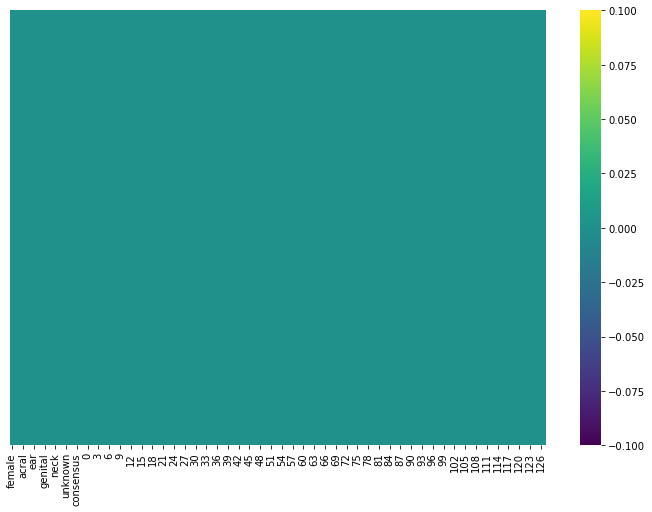

In [67]:
# Checking Null values
plt.figure(figsize=(12,8))
sns.heatmap(X_labels.isnull(),cmap='viridis',yticklabels=False)

In [68]:
# Splitting the dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_labels,y_label,test_size=0.10,random_state=28,stratify=y_label)

# Creating Models from Predictions

## 1. Random Forest Classifier

In [69]:
from sklearn.ensemble import RandomForestClassifier
rfc  = RandomForestClassifier(random_state=28)
rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=28)

In [70]:
y_pred = rfc.predict(X_test)

In [71]:
confusion_matrix(y_test,y_pred)

array([[ 14,   2,   6,   0,   5,   6,   0],
       [  5,  25,   6,   3,  10,   2,   0],
       [  5,   4,  51,   2,  33,  15,   0],
       [  0,   2,   0,   4,   5,   1,   0],
       [  0,   3,  12,   0, 636,  20,   0],
       [  2,   3,   9,   0,  40,  57,   0],
       [  0,   2,   0,   0,   0,   0,  12]])

In [72]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.54      0.42      0.47        33
           1       0.61      0.49      0.54        51
           2       0.61      0.46      0.53       110
           3       0.44      0.33      0.38        12
           4       0.87      0.95      0.91       671
           5       0.56      0.51      0.54       111
           6       1.00      0.86      0.92        14

    accuracy                           0.80      1002
   macro avg       0.66      0.58      0.61      1002
weighted avg       0.78      0.80      0.79      1002



In [73]:
accuracy_score(y_pred,y_test)

0.7974051896207585

## 2. XGBOOST Classifier

In [74]:
# XGBOOST
import xgboost as xgb
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=-1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=1855, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=0)

In [75]:
clf.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, nthread=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=1855, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=1855, silent=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=0)

In [76]:
y_pred = clf.predict(X_test)

In [77]:
confusion_matrix(y_test,y_pred)

array([[ 13,   3,   5,   0,   6,   6,   0],
       [  5,  25,   7,   1,  10,   2,   1],
       [  4,   4,  61,   0,  30,  11,   0],
       [  0,   0,   2,   5,   5,   0,   0],
       [  0,   3,   9,   0, 642,  17,   0],
       [  1,   1,   7,   0,  43,  59,   0],
       [  0,   2,   0,   0,   0,   0,  12]])

In [78]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.57      0.39      0.46        33
           1       0.66      0.49      0.56        51
           2       0.67      0.55      0.61       110
           3       0.83      0.42      0.56        12
           4       0.87      0.96      0.91       671
           5       0.62      0.53      0.57       111
           6       0.92      0.86      0.89        14

    accuracy                           0.82      1002
   macro avg       0.73      0.60      0.65      1002
weighted avg       0.80      0.82      0.80      1002



In [79]:
print(accuracy_score(y_test,y_pred))

0.8153692614770459


## 3. Logistic Regression**

In [80]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [81]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.60      0.36      0.45        33
           1       0.69      0.57      0.62        51
           2       0.68      0.58      0.63       110
           3       0.78      0.58      0.67        12
           4       0.87      0.95      0.91       671
           5       0.61      0.50      0.55       111
           6       1.00      0.86      0.92        14

    accuracy                           0.82      1002
   macro avg       0.75      0.63      0.68      1002
weighted avg       0.80      0.82      0.81      1002



In [82]:
print(accuracy_score(y_test,y_pred))

0.8173652694610778


### From the 3 models created, Logistic Regression with features extracted from CNN Model gave highest accuracy of 85.02%